# My First Hierarchical Classifier 

In this tutorial we will learn how to define a hierarichal classifier and how to use it for predictions. 


In [2]:
import matplotlib.pyplot as plt

import load_datafiles
from classifiers import classifiers, markers, calc_operations
from data_prep import Dataset
from hierarchical_classification import HierarchicalClassificationModel
from flat_classification import FlatClassificationModel

from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import metrics
from sklearn.tree import plot_tree

import feature_extraction as fe


## Load The Data

Let's load the dataframe and it's associated information using the load_datafiles package. 
The function load_data() returns the dataframe, the binary labels (fault, no fault), the number of instances of every class, and the extended labels (binary, fault, severity). 

In [2]:
dff = load_datafiles.load_data()

Let's inspect this further, we will print the datset and the sizes of the different classes. 

In [3]:
dff[0]

mean       rms  skewness   kurtosis  foureir_max
0     0.012005  0.073256 -0.137322  -0.045824     0.057094
1     0.012790  0.079035 -0.062348  -0.184580     0.062647
2     0.011959  0.074338  0.025960  -0.221760     0.059279
3     0.010285  0.073688 -0.147535  -0.069035     0.055726
4     0.011016  0.072112 -0.083451  -0.205601     0.055088
...        ...       ...       ...        ...          ...
1099  0.020819  0.517453 -0.015500   7.790141     0.210134
1100  0.025541  0.626235 -0.258662  17.611038     0.269639
1101  0.021389  0.724116 -0.422400   6.131897     0.336415
1102  0.023087  0.802284  0.202400  17.138865     0.355897
1103  0.023466  0.385616 -0.067607   5.576510     0.152371

[1104 rows x 5 columns]

In [4]:
dff[2]

{'normal_0': 119,
 'inner_7_0': 119,
 'inner_14_0': 31,
 'inner_21_0': 119,
 'ball_7_0': 119,
 'ball_14_0': 121,
 'ball_21_0': 119,
 'outer_7_0': 118,
 'outer_14_0': 119,
 'outer_21_0': 120}

## Creating the Dataset

In this section we will create the dataset using the Dataset class. A Dataset object holds the raw data and their required labels for every possible level: binary, fault, or severity. 


In [5]:
dataset = Dataset(*dff)

## Setting up the Hierarchical Classifier

Next we will use our classification class to define an object of a hierarichal classifier. The constructor takes the dataset as a parameter.

In [6]:
hierclf = HierarchicalClassificationModel(dataset)

Now, we need to define the types of the binary, fault and severity classifiers of the object. These are by default set to Desicion trees but for learning purposes, we will set them all to decision trees using the set_classifiers function. 

To check out what classifiers are available go to the classifiers.py file, where classifiers and their corresponding indices are shown. For now we will use the index 5 that corresponds to decision trees. 

Note that the sevirity level takes 3 different classifier types, because for every fault a different classifier can be used to predict the severity. The order is: binary, fault, inner severity, ball severity, and outer severity.

In [7]:
hierclf.set_classifiers([5, 5, 5, 5, 5])

## Inspecting The Binary Level

Now we will check the individual levels of the classifier, we will start by the binary data and split it to a training and testing set. 

By splitting the dataset to t a train and test splits, we can get the accuracy and other metrics of the binary classifier in the first level.

In [8]:
x, y = hierclf.binary_data

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state= 42)

To train the classifier, we use the function fit_binary, which returns the number of operations our classifier needs to perform to predict an instance.

In [9]:
hierclf.fit_binary(x_train.index)

1

Let's check if our classifier is indeed a desicion tree.

In [10]:
clf = hierclf.clf_binary
clf

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Perfect! Now let's get the predictions and calculate our classifiers accuracy.

In [11]:
y_pred = clf.predict(x_test)

metrics.accuracy_score(y_test, y_pred)

1.0

How amazing! Our classifier could predict the right class (fault,no fault) 100% of the times.


### Visualizing The Binary Classifier

To understand our classifier's behaviour we will visualize the tree.

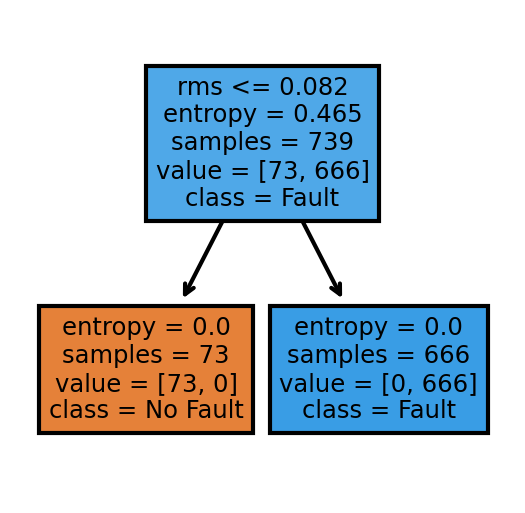

In [12]:
fn = fe.get_feature_names()

cn=['No Fault', 'Fault']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

Looks like that any instance of a rms value more than 0.082 is a no fault instance.

## Inspecting The Fault Level

Let's inspect the next level, can our classifier predict which fault is present?

In [13]:
from sklearn import metrics
from sklearn.model_selection import train_test_split


x_f, y_f = hierclf.fault_data
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(
    x_f, y_f, test_size=0.33, random_state=42)

hierclf.fit_fault(x_test_f.index)

y_pred_f = hierclf.clf_fault.predict(x_test_f)

metrics.accuracy_score(y_test_f, y_pred_f)


0.8680981595092024

Our class has an accuracy of 86.8% which is not bad. 

### Visualizing The Fault Classifier

Let us see how the tree looks like.

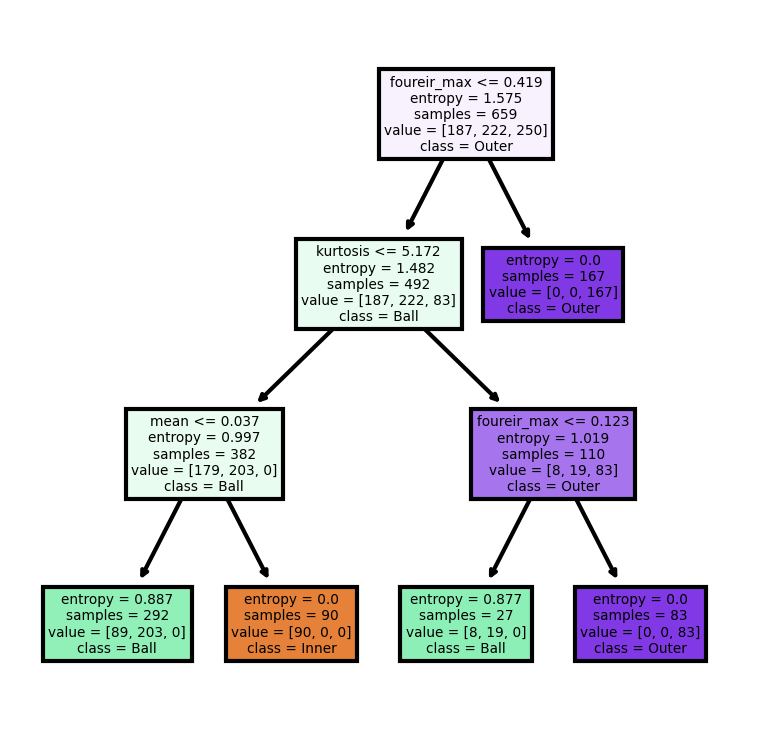

In [14]:
cn=['Inner', 'Ball', 'Outer']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
plot_tree(hierclf.clf_fault,
               feature_names = fn, 
               class_names=cn,
               filled = True);

In [15]:
from sklearn import metrics
from sklearn.model_selection import train_test_split


x_sev, y_sev = hierclf.sev_data_inner
x_train_sev, x_test_sev, y_train_sev, y_test_sev = train_test_split(
    x_sev, y_sev, test_size=0.33, random_state=42)

hierclf.fit_severity(x_test_sev.index, 2)

y_pred_sev = hierclf.clf_sev_inner.predict(x_test_sev)

metrics.accuracy_score(y_test_sev, y_pred_sev)

1.0

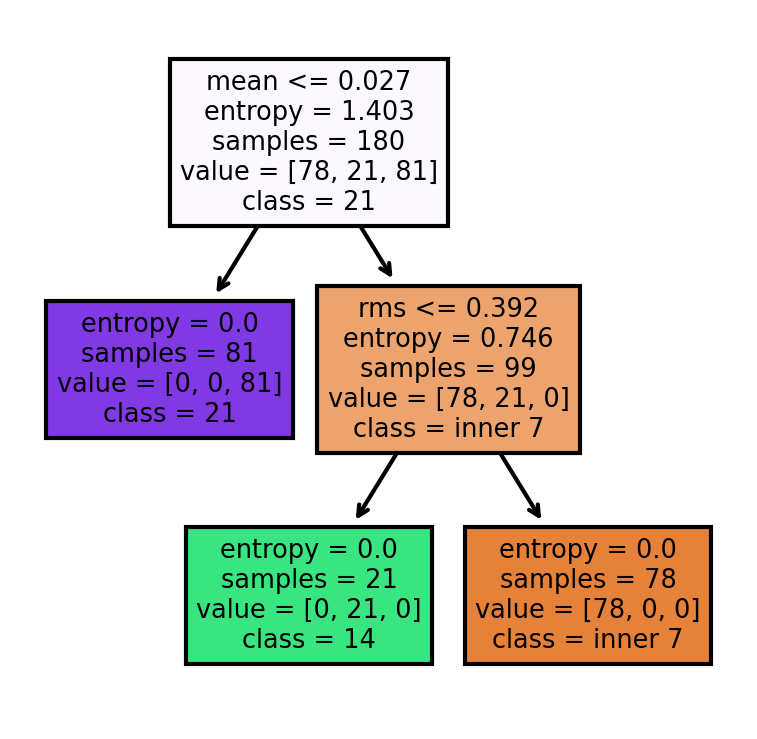

In [16]:
cn=['inner 7', '14', '21']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
plot_tree(hierclf.clf_sev_inner,
               feature_names = fn, 
               class_names=cn,
               filled = True);

## Overall accuracy and Hierachical Measures 

Pretty intersting! However to get the actual accuracy of the hierarchical classifier on all levels, we need to calculate the hierarchical measures.

The get_scores function returns the accuracy, hierachical precision, hierarchical recall and hierarchical f-measure. It also returns the average total number of operations needed to predict an instance.

In [17]:
hierclf.get_scores(x_train.index, x_test.index)


((0.8301369863013699, 0.8358774593775703, 0.883718727977449),
 5.854794520547945)

So our classifier has an accuracy of 83%, a hierarchical precision of 83.58%, a hierarchical recall of 88.37% and all of this only by performing an average of 5.854 operations for every prediction! 

### K-fold Corss Validation

Another intersting function is the get_scores_k_fold, it performs a k-fold cross validation on the dataset and returns also  accuracy, hierachical precision, hierarchical recall and hierarchical f-measure and the average operations.

Let's see the results of performin a 10-fold cross validation. 

In [18]:
hierclf.get_scores_k_fold(splits = 10)

((0.8595741195741194, 0.832007615426581, 0.8900502136752138),
 5.943390663390663)

## The Flat Classifier

So  we inspected the hierarchical classifier. What about flat classifiers? 

To set up a flat classifier, we will use the class FlatClassificationModel.

In [19]:
flat_clf = FlatClassificationModel(dataset)
flat_clf.set_classifier(5)
flat_clf.get_scores(x_train.index, x_test.index)

((0.6958904109589041, 0.6008768304539032, 0.7888266987104198), 3)

The flat classifier has a significantly worse accuracy.

## Comparing Classifiers

To find out which classifiers perform better we can use the get_score_diagram function from the Diagrams package.
The function returns diagrams showing the perfomance measures vs. number of opeerators for different classifiers.

The measures are calculated over a 10-fold cross validation process.

Circles represent desicion trees, starts represnt random forests and plus signs represent knns. Green is flat and red is hierarchical. The Blue triangles are a mix of decision trees and random forests.

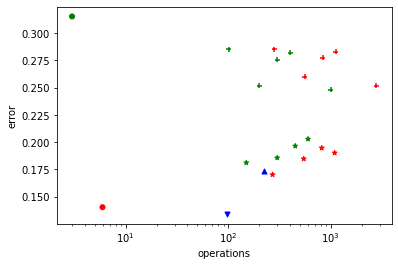

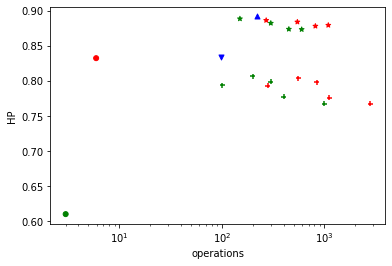

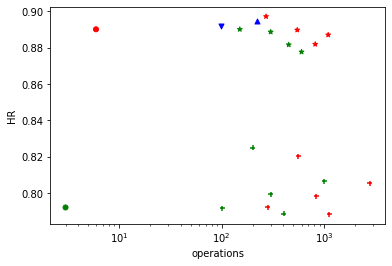

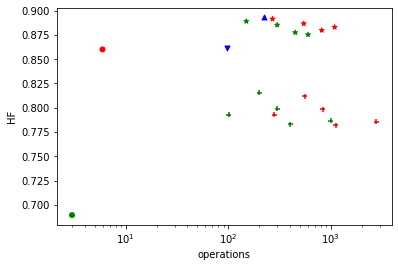

In [1]:
from Diagrams import get_score_diagram 

get_score_diagram(splits_num = 10)

That's it ! Check out our next tutorial: [Q Learning](https://gitlab.com/aliyahammad95/condition-monitoring/-/blob/master/src/Q%20learning.ipynb)
